# DETR - Detection Transformer
Reference: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb


Original DETR paper: https://arxiv.org/abs/2005.12872

Original DETR repo: https://github.com/facebookresearch/detr


In [1]:
!python --version

Python 3.10.0


In [204]:
# Install or upgrade pip
# !python -m pip install --upgrade pip

# Install required packages
# !pip install supervision==0.3.0
# !pip install transformers
# !pip install pytorch-lightning
# !pip install timm
# !pip install cython
# !pip install pycocotools
# !pip install scipy


In [2]:
!pip --version

pip 24.0 from C:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\pip (python 3.10)



In [3]:
import torch
torch.__version__

'2.0.1+cu117'

In [4]:
import supervision
import transformers

supervision.__version__ , transformers.__version__

('0.21.0', '4.40.1')

In [5]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.3.0


## Create COCO data loaders

### About dataset:

#### number of classes - 4  ['angle', 'fracture', 'line', 'messed_up_angle'


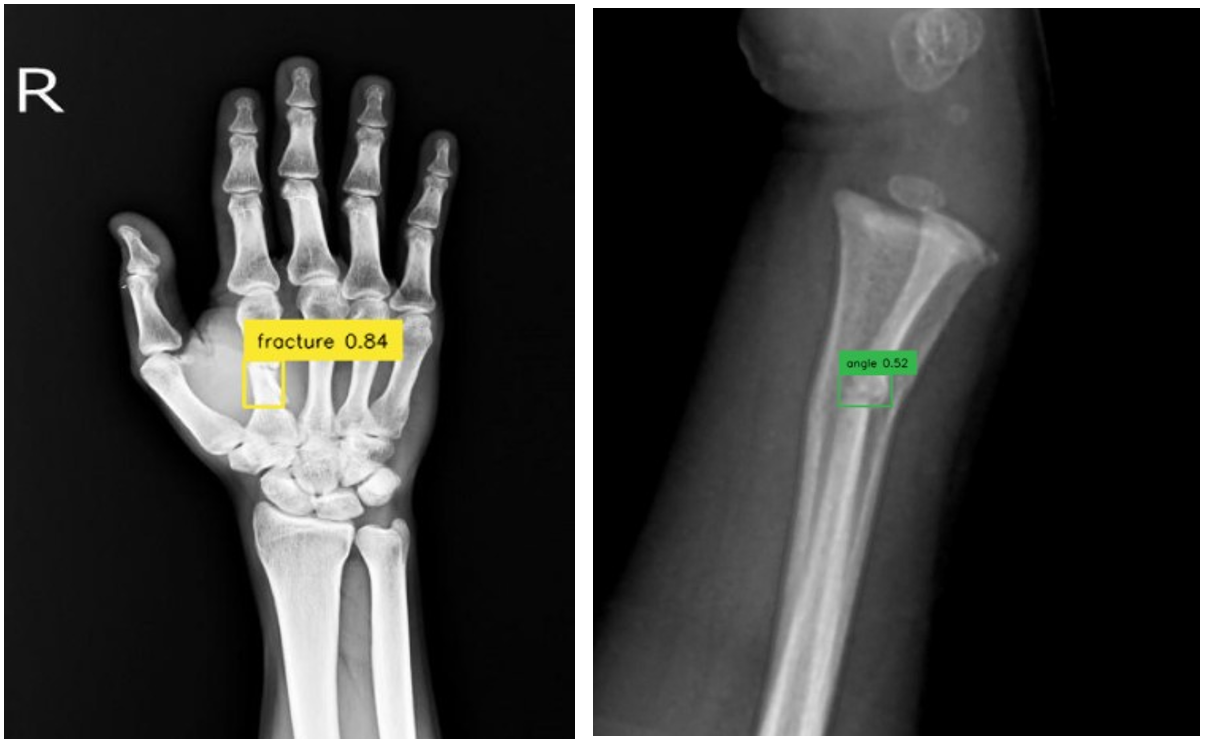]

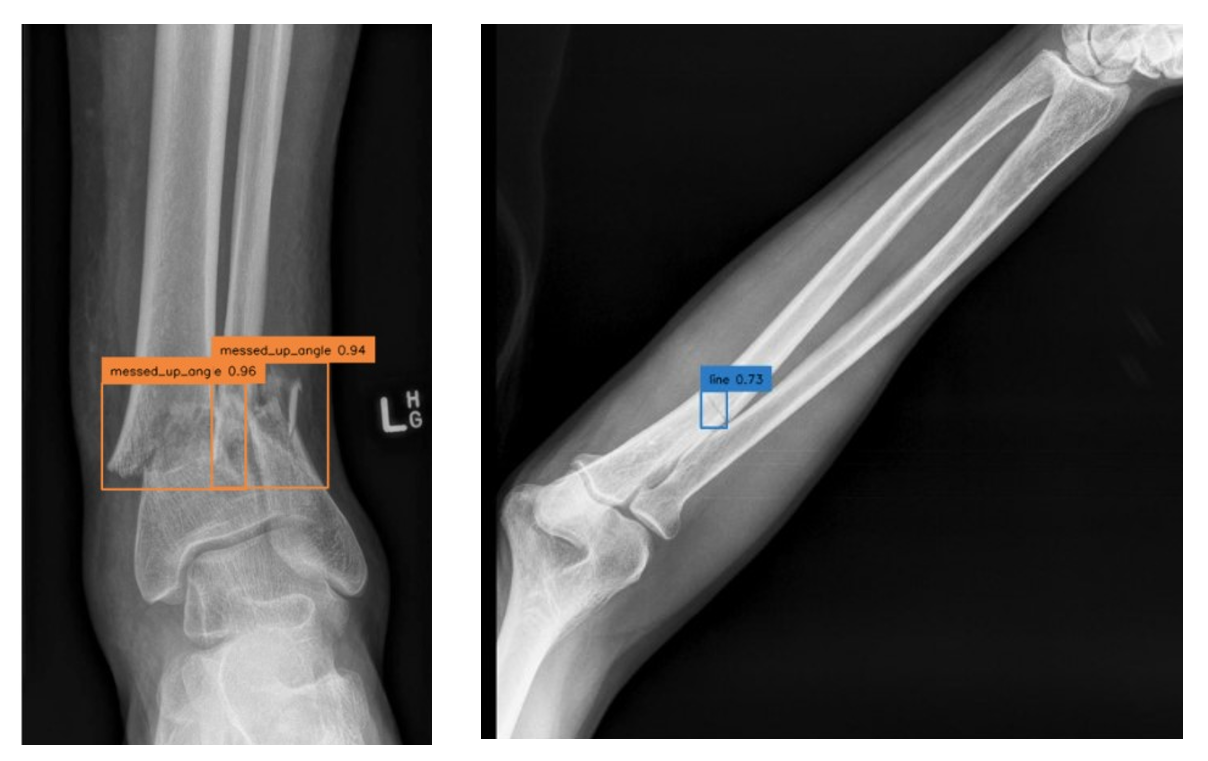

In [6]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [7]:
import os
import torchvision

dataset = './dataset'

TRAIN_ANNOTATION_FILE = os.path.join(dataset, "train/_annotations.coco.json")
VAL_ANNOTATION_FILE = os.path.join(dataset, "val/_annotations.coco.json")
TEST_ANNOTATION_FILE = os.path.join(dataset, "test/_annotations.coco.json")
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, annotation_file_path: str, image_processor):
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, annotation_file_path=TRAIN_ANNOTATION_FILE, image_processor=image_processor)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, annotation_file_path=VAL_ANNOTATION_FILE, image_processor=image_processor)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, annotation_file_path=TEST_ANNOTATION_FILE, image_processor=image_processor)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #27


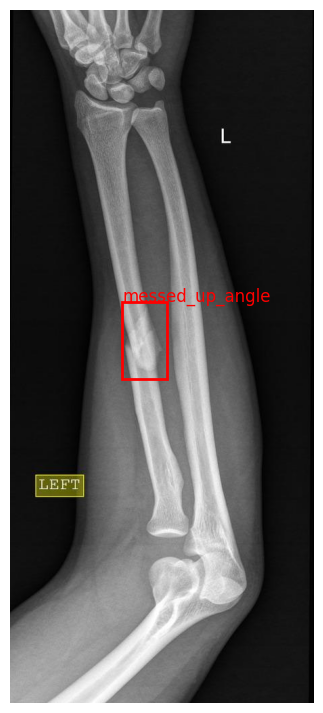

In [8]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Helper function to draw bounding boxes
def draw_boxes(image, annotations, id2label):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for annotation in annotations:
        bbox = annotation['bbox']
        class_id = annotation['category_id']
        label = id2label[class_id]

        # Create a rectangle patch
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1], label, fontsize=12, color='red')

    plt.axis('off')
    plt.show()

# Select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# Load image and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB

# Get category ID to label mapping
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

# Draw bounding boxes on the image
draw_boxes(image, annotations, id2label)


In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [30]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 50

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.29it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 11:   6%|▌         | 5/82 [00:19<05:00,  0.26it/s, v_num=3] 

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# Save and load model

In [12]:

MODEL_PATH = './lightning_logs/version_3/checkpoints/'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

Image #42


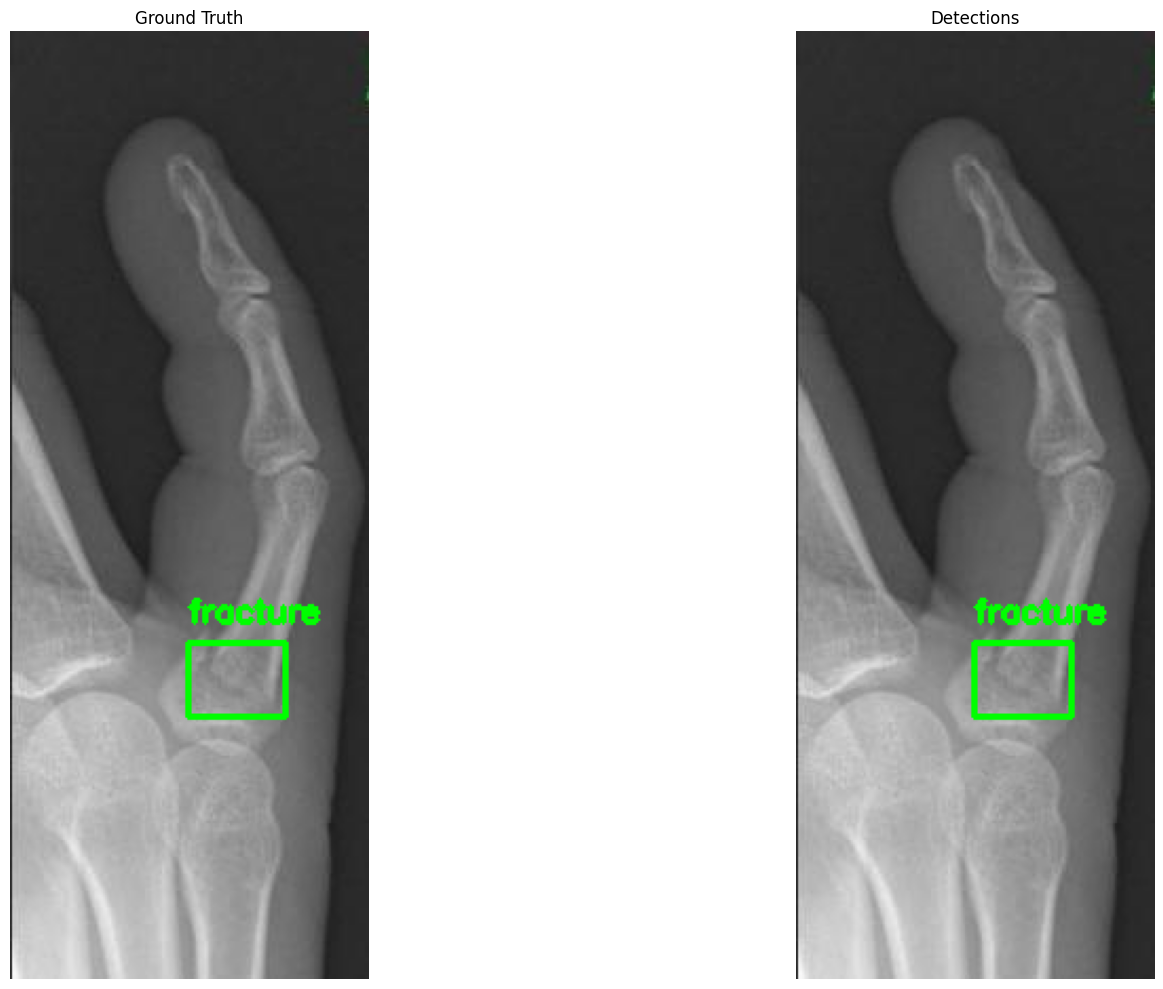

In [13]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

#confidence threshold of an object
CONFIDENCE_THRESHOLD = 0.5
# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

# Select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# Load image and annotations
image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
def draw_boxes(image, annotations, id2label):
    for annotation in annotations:
        bbox = annotation['bbox']
        class_id = annotation['category_id']
        label = id2label[class_id]
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0, 255, 0), 2)
        cv2.putText(image, label, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Function to annotate detections with confidence
def annotate_detections(image, detections, id2label):
    for detection in detections:
        bbox, confidence, class_id = detection[:3]  # Assuming detection format is [bbox, confidence, class_id, ...]
        label = f"{id2label[class_id]} {confidence:.2f}"
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)
        cv2.putText(image, label, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Annotate ground truth
draw_boxes(image, annotations, id2label)
frame_ground_truth = image.copy()

# Annotate detections
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # Post-process detections
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_THRESHOLD,
        target_sizes=target_sizes
    )[0]

    detections = results['boxes'].cpu().numpy()
    confidences = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()

    detections_with_confidence = []
    for bbox, confidence, class_id in zip(detections, confidences, labels):
        detections_with_confidence.append([bbox, confidence, class_id])

    # Annotate detections on image copy
    image_with_detections = image.copy()
    annotate_detections(image_with_detections, detections_with_confidence, id2label)

# %matplotlib inline # Remove this line, we won't use it anymore

# Display ground truth and detections side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].set_title('Ground Truth')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))
axs[1].set_title('Detections')
axs[1].axis('off')

plt.tight_layout()
plt.show()
